In [88]:
#Importamos las librerias a utilizar.
import pandas as pd
import numpy as np
import string 
string.punctuation
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords.words('english')
import re
import unicodedata
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re
from nltk.tokenize import word_tokenize
from sklearn import linear_model
from sklearn import metrics
from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer
import neattext as nt

import nltk
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jiio2\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jiio2\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [89]:
#Cargamos el dataset de entrenamiento. 
df_train=pd.read_csv("train.csv")
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [90]:
#Cargamos el dataset de test. 
df_test=pd.read_csv('test.csv')
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [91]:
#Cargamos el sample submission
df_sample=pd.read_csv('sample_submission.csv')
df_sample.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


#### Preprosesamiento de Datos

In [92]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [93]:
#Vemos los valores de target
df_train['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

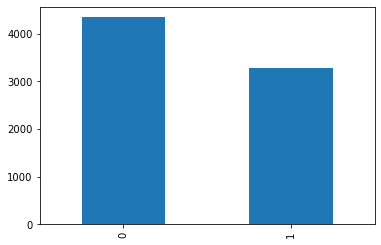

In [94]:
#Graficamos los valores de target
df_train['target'].value_counts().plot(kind='bar')

Podemos observar que la mayoria de tweets son falsos.

In [95]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [96]:
#Vemos los valores de keyword.
df_train['keyword'].value_counts()

fatalities               45
armageddon               42
deluge                   42
damage                   41
body%20bags              41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

In [97]:
#Vemos los datos estadisticos de Keyword
df_train.groupby(['keyword']).mean()

,id,target
keyword,,
ablaze,70.388889,0.361111
accident,121.800000,0.685714
aftershock,171.323529,0.000000
airplane%20accident,220.142857,0.857143
ambulance,269.052632,0.526316
...,...,...
wounded,10609.135135,0.702703
wounds,10662.393939,0.303030
wreck,10708.513514,0.189189


In [98]:
df_train.describe(include='all')

,id,keyword,location,text,target
count,7613.000000,7552,5080,7613,7613.00000
unique,NaN,221,3341,7503,NaN
top,NaN,fatalities,USA,11-Year-Old Boy Charged With Manslaughter of T...,NaN
freq,NaN,45,104,10,NaN
mean,5441.934848,NaN,NaN,NaN,0.42966
std,3137.116090,NaN,NaN,NaN,0.49506
min,1.000000,NaN,NaN,NaN,0.00000
25%,2734.000000,NaN,NaN,NaN,0.00000
50%,5408.000000,NaN,NaN,NaN,0.00000
75%,8146.000000,NaN,NaN,NaN,1.00000


In [99]:
df_train.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


#### Limpieza del Texto

In [100]:
EMOJIS = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}
URLPATTERN        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
USERPATTERN       = '@[^\s]+'
SEQPATTERN   = r"(.)\1\1+"
SEQREPLACE = r"\1\1"

In [192]:
def resultado_class(X):
    media = np.mean(X)
    
    if media >=0.10 and media < 0.15:
        return "Es poco probable que el tweet sea de un desastre"
    elif media >=0.15 and media <0.25:
        return "Es bastante probable que el tweet sea de un desastre"
    elif media >= 0.25 and media <0.50:
        return "Es altamente probable que el tweet sea de un desastre"
    elif media >=0.50 and media <=1:
        return "El tweet es de un desastre"
    else: 
        return "El Tweet no es de un desastre"

In [102]:
def limpiar(text):

    text = nt.TextFrame(str(text)).remove_stopwords(lang = "en")
    text = nt.TextFrame(str(text)).remove_emails()
    text = nt.TextFrame(str(text)).remove_numbers()
    text = nt.TextFrame(str(text)).remove_phone_numbers()
    text = nt.TextFrame(str(text)).remove_btc_address()
    text = nt.TextFrame(str(text)).remove_urls()
    text = nt.TextFrame(str(text)).remove_emojis()
    text = nt.TextFrame(str(text)).remove_html_tags()
    text = nt.TextFrame(str(text)).remove_puncts()
    text = nt.TextFrame(str(text)).remove_special_characters()
    text = nt.TextFrame(str(text)).remove_stopwords(lang = "en")
    text = text.word_tokens()
    return text


In [103]:
#Quitamos los emojis, url's, signos.
def tweetsLimpios(text):
    lowercase = text.lower()
    punc_removal = [char for char in lowercase if char not in string.punctuation]
    punc_removal_joined = ''.join(punc_removal)
    url_removal = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', punc_removal_joined, flags=re.MULTILINE)
    for emoji in EMOJIS.keys():
        url_removal = url_removal.replace(emoji, "EMOJI" + EMOJIS[emoji])  

    emoji_removal=url_removal
    stopwords_removal = [word for word in emoji_removal.split() if word not in stopwords.words('english')]
    return stopwords_removal

In [104]:
df_train['textoLimpio']=df_train['text'].apply(limpiar).astype(str)

In [105]:
df_test['textoLimpio']=df_test['text'].apply(limpiar).astype(str)

In [106]:
df_train.head()

,id,keyword,location,text,target,textoLimpio
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,"['Deeds', 'Reason', 'earthquake', 'ALLAH', 'Fo..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,"['Forest', 'fire', 'near', 'La', 'Ronge', 'Sas..."
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,"['residents', 'asked', 'shelter', 'place', 'no..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,"['people', 'receive', 'wildfires', 'evacuation..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,"['got', 'sent', 'photo', 'Ruby', 'Alaska', 'sm..."


In [107]:
df_train_clean=df_train[['textoLimpio','target']]

In [108]:
df_train_clean.head()

,textoLimpio,target
0,"['Deeds', 'Reason', 'earthquake', 'ALLAH', 'Fo...",1
1,"['Forest', 'fire', 'near', 'La', 'Ronge', 'Sas...",1
2,"['residents', 'asked', 'shelter', 'place', 'no...",1
3,"['people', 'receive', 'wildfires', 'evacuation...",1
4,"['got', 'sent', 'photo', 'Ruby', 'Alaska', 'sm...",1


#### Tokenización

In [109]:
#Tokenizamos la columna de textoLimpio
max_fatures = 2000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(df_train_clean['textoLimpio'].values)
X = tokenizer.texts_to_sequences(df_train_clean['textoLimpio'].values)
X = pad_sequences(X)

## LSTM Model 

In [110]:
#Creamos el modelo LSTM
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
#Resumen del modelo
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 17, 128)           256000    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 17, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 196)               254800    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 394       
Total params: 511,194
Trainable params: 511,194
Non-trainable params: 0
_________________________________________________________________
None


In [111]:
#Separamos el dataset en train y test para evaluarlos en el modelo. 
Y = pd.get_dummies(df_train_clean['target']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.33, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(5100, 17) (5100, 2)
(2513, 17) (2513, 2)


In [112]:
#Vemos el funcionamiento del modelo
batch_size = 16
history = model.fit(X_train, Y_train, epochs = 19, batch_size=batch_size, verbose = 2)

Epoch 1/19
319/319 - 8s - loss: 0.5420 - accuracy: 0.7327
Epoch 2/19
319/319 - 6s - loss: 0.3896 - accuracy: 0.8306
Epoch 3/19
319/319 - 6s - loss: 0.3435 - accuracy: 0.8539
Epoch 4/19
319/319 - 6s - loss: 0.2983 - accuracy: 0.8725
Epoch 5/19
319/319 - 6s - loss: 0.2631 - accuracy: 0.8931
Epoch 6/19
319/319 - 6s - loss: 0.2312 - accuracy: 0.9073
Epoch 7/19
319/319 - 6s - loss: 0.2042 - accuracy: 0.9161
Epoch 8/19
319/319 - 6s - loss: 0.1771 - accuracy: 0.9276
Epoch 9/19
319/319 - 6s - loss: 0.1622 - accuracy: 0.9339
Epoch 10/19
319/319 - 6s - loss: 0.1472 - accuracy: 0.9414
Epoch 11/19
319/319 - 6s - loss: 0.1339 - accuracy: 0.9471
Epoch 12/19
319/319 - 6s - loss: 0.1252 - accuracy: 0.9512
Epoch 13/19
319/319 - 6s - loss: 0.1180 - accuracy: 0.9496
Epoch 14/19
319/319 - 6s - loss: 0.1029 - accuracy: 0.9573
Epoch 15/19
319/319 - 6s - loss: 0.0992 - accuracy: 0.9575
Epoch 16/19
319/319 - 6s - loss: 0.0901 - accuracy: 0.9635
Epoch 17/19
319/319 - 6s - loss: 0.0881 - accuracy: 0.9614
Epoch 

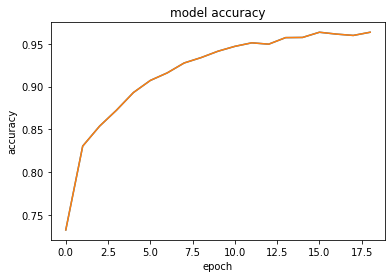

In [113]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

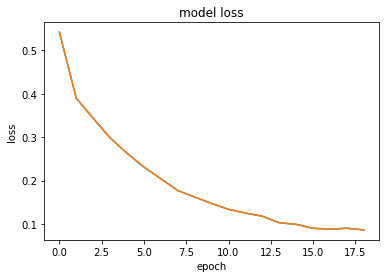

In [114]:
plt.plot(history.history['loss'])
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

En estas graficas podemos obserbar como el modelo tiende a tener su accuracy exponencialmente de una manera positiva, al mismo tiempo que la perdida es menor, lo que nos brinda una buena confiabilidad en el algoritmo. 

### Predicciones con el modelo LSTM

In [115]:
df_test.head()

,id,keyword,location,text,textoLimpio
0,0,NaN,NaN,Just happened a terrible car crash,"['happened', 'terrible', 'car', 'crash']"
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...","['Heard', 'earthquake', 'different', 'cities',..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...","['forest', 'fire', 'spot', 'pond', 'geese', 'f..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,"['Apocalypse', 'lighting', 'Spokane', 'wildfir..."
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,"['Typhoon', 'Soudelor', 'kills', 'China', 'Tai..."


In [116]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           3263 non-null   int64 
 1   keyword      3237 non-null   object
 2   location     2158 non-null   object
 3   text         3263 non-null   object
 4   textoLimpio  3263 non-null   object
dtypes: int64(1), object(4)
memory usage: 127.6+ KB


In [117]:
#Tokenizamos el textoLimpio
max_fatures = 2000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(df_test['textoLimpio'].values)
X = tokenizer.texts_to_sequences(df_test['textoLimpio'].values)
X = pad_sequences(X)

In [118]:
#Creamos la predicción
pred=model.predict(X)

In [119]:
labels=[0,1]

In [120]:
pred.shape

(3263, 2)

In [121]:
#Vemos los valores de la predicción. 
pred

array([[4.6125168e-01, 5.3874826e-01],
       [2.2728470e-08, 1.0000000e+00],
       [3.5747036e-03, 9.9642533e-01],
       ...,
       [4.1662586e-01, 5.8337408e-01],
       [9.8218232e-01, 1.7817687e-02],
       [9.9616027e-01, 3.8396884e-03]], dtype=float32)

In [122]:
#Para guardar la prediccion
tweetPredict=[]

In [123]:
df_test.head()

,id,keyword,location,text,textoLimpio
0,0,NaN,NaN,Just happened a terrible car crash,"['happened', 'terrible', 'car', 'crash']"
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...","['Heard', 'earthquake', 'different', 'cities',..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...","['forest', 'fire', 'spot', 'pond', 'geese', 'f..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,"['Apocalypse', 'lighting', 'Spokane', 'wildfir..."
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,"['Typhoon', 'Soudelor', 'kills', 'China', 'Tai..."


In [124]:
df_test['id'][0]

0

In [125]:
#Creamos una funcion que guarde los datos del id, target y la prediccion. 
idx=0
for p in pred:
    predict=[]
    t_id=df_test['id'][idx]
    idx+=1
    target=labels[np.argmax(p)]
    predict.append(t_id)
    predict.append(target)
    tweetPredict.append(predict)
    

In [126]:
df_sub=pd.DataFrame(tweetPredict,columns=["id","target"])

In [127]:
df_sub.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,0
4,11,1


In [128]:
len(df_sub)

3263

In [129]:
#Vemos la cantidad de 0 y 1 segun las predicciones. 
df_sub['target'].value_counts()

0    1789
1    1474
Name: target, dtype: int64

#### Visualización 

##### Resultados obtenidos con la predicción 

In [130]:
pie = df_sub.groupby("target").count()

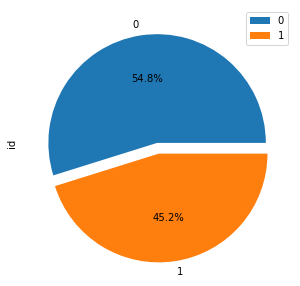

In [131]:
pie.plot.pie(y='id', figsize=(5, 5), autopct='%1.1f%%', explode=(0, 0.1))

Observamos que la cantidad de tweets falsos es mayor a la de verdaderos. 

##### Resultados obtenidos comparando la predicción con la data de test

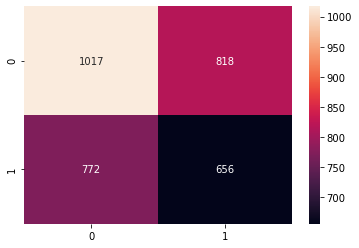

In [132]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
dataTest=pd.read_csv('test2.csv')
cm = confusion_matrix(dataTest.target, df_sub.target)
f = sns.heatmap(cm, annot=True, fmt='d')

Podemos observar que se obtuvieron resultados distintos cuando los comparamos, pero siempre la mayoria de tweets resultan falsos. 

In [133]:
df_sub.to_csv('submission_lstm.csv',index=False)

In [134]:
def save_prediction(pred,model):
    df_test=pd.read_csv('test.csv')
    submission_list=[]
    idx=0
    tweet_predict=[]
    for p in pred:
        predict=[]
        t_id=df_test['id'][idx]
        idx+=1
        target=p
        predict.append(t_id)
        predict.append(target)
        tweet_predict.append(predict)
    df_sub=pd.DataFrame(tweet_predict,columns=['id','target'])
    df_sub.to_csv('submission_'+model+".csv",index=False)
    print(model+"- model prediction")
    print(df_sub['target'].value_counts())

# Regresión Logística + CountVectorized

In [135]:
#Creamos una nueva columna llamada kfold y la llenamos con -1
df_train["kfold"]=-1

In [136]:
df_train=df_train.sample(frac=1).reset_index(drop=True)

In [137]:
y=df_train.target

In [138]:
kf=model_selection.StratifiedKFold(n_splits=4)

In [139]:
for f,(t_,v_) in enumerate(kf.split(X=df_train,y=y)):
    df_train.loc[v_,'kfold']=f

In [140]:
#Vemos los datos. 
df_train.head()

,id,keyword,location,text,target,textoLimpio,kfold
0,9552,threat,"London, UK",Generational Û÷British schismÛª over privacy...,0,"['Generational', 'British', 'schism', 'privacy...",0
1,6779,lightning,"Leesburg, FL",.@dantwitty52 shuts the door on the Boom in th...,0,"['shuts', 'door', 'Boom', 'half', 'Lightning',...",0
2,10289,weapon,"BROOKLYN, NYC",Please allow me to reiterate it's not the weap...,1,"['allow', 'reiterate', 'weapon', 'mindset', 'i...",0
3,10268,war%20zone,The D,#DebateQuestionsWeWantToHear If U start anothe...,1,"['DebateQuestionsWeWantToHear', 'U', 'start', ...",0
4,9324,survive,Back East in PA,Help me survive the zombie apocalypse at the Z...,0,"['Help', 'survive', 'zombie', 'apocalypse', 'Z...",0


In [141]:
df_train['kfold'].value_counts()

0    1904
3    1903
2    1903
1    1903
Name: kfold, dtype: int64

In [142]:
#Creamos la funcion para nuestro modelo 
for fold_ in range(5):
    train_df=df_train[df_train.kfold!=fold_].reset_index(drop=True)
    if fold_==4:
        train_df=df_train.reset_index(drop=True)
        test_df=df_test.reset_index(drop=True)
    else:
        test_df=df_train[df_train.kfold==fold_].reset_index(drop=True)
    #Utilizamos el CountVectorizer con el word_tokenize de NLTK y la funcion se tokeniza
    count_vec=CountVectorizer(
        tokenizer=word_tokenize,
        token_pattern=None)
    #Se ajusta count_vec en la revision de los datos de entrenamiento
    count_vec.fit(train_df.text)
    #Se transforman las revisiones de los datos de entrenamiento y validación
    x_train=count_vec.transform(train_df.text)
    x_test=count_vec.transform(test_df.text)
    #Se inicia el modelo de regresion Logistica
    model_logistic=linear_model.LogisticRegression(max_iter=1000)
    #Se ajustar el modelo a los datos de entrenamiento y a los sentimientos
    model_logistic.fit(x_train,train_df.target)
    preds_log=model_logistic.predict(x_test)
    #Se calcula la precision 
    if fold_!=4:
        accuracy=metrics.accuracy_score(test_df.target,preds_log)
        print(f"Fold:{fold_}")
        print(f"Accuracy={accuracy}")
    

Fold:0
Accuracy=0.7914915966386554
Fold:1
Accuracy=0.8050446663163426
Fold:2
Accuracy=0.7976878612716763
Fold:3
Accuracy=0.8008407777193904


Se mantienen un accuracy de valores similares al realizar cuatro pruebas con el modelo 

#### Predicción con el modelo de Regresión Logística + CountVectorized

In [145]:
set(preds_log)

{0, 1}

In [146]:
len(preds_log)

3263

In [147]:
#Vemos el valor de target basados en la prediccion. 
save_prediction(preds_log,model='logistic')

logistic- model prediction
0    2061
1    1202
Name: target, dtype: int64


#### Visualización 

##### Resultados obtenidos con la predicción 

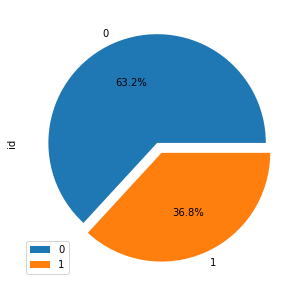

In [148]:
logs = pd.read_csv("submission_logistic.csv")
pie = logs.groupby("target").count()
pie.plot.pie(y='id', figsize=(5, 5), autopct='%1.1f%%', explode=(0, 0.1))

En este modelo se observa una diferencia un poco mas notoria con respecto a la cantidad de tweets falsos que se predicen. 

##### Resultados obtenidos comparando la predicción con la data de test

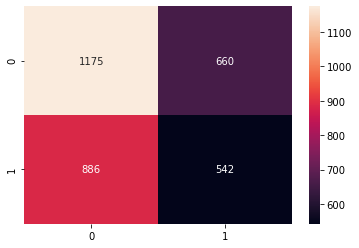

In [149]:
cm = confusion_matrix(dataTest.target, logs.target)
f = sns.heatmap(cm, annot=True, fmt='d')

Podemos observar que se obtuvieron resultados distintos cuando los comparamos, pero siempre la mayoria de tweets resultan falsos. 

# Naive bayes

In [150]:
#Importamos el modelo de naive bayes
from sklearn import naive_bayes

In [151]:
#Creamos una funcion para el modelo.
for fold_ in range(5):
    train_df=df_train[df_train.kfold!=fold_].reset_index(drop=True)
    if fold_==4:
        train_df=df_train.reset_index(drop=True)
        test_df=df_test.reset_index(drop=True)
    else:
        test_df=df_train[df_train.kfold==fold_].reset_index(drop=True)
    #Utilizamos el CountVectorizer con el word_tokenize de NLTK y la funcion se tokeniza
    count_vec=CountVectorizer(
        tokenizer=word_tokenize,
        token_pattern=None)
    #Se ajusta count_vec en la revision de los datos de entrenamiento
    count_vec.fit(train_df.text)
    #Se transforman las revisiones de los datos de entrenamiento y validación
    x_train=count_vec.transform(train_df.text)
    x_test=count_vec.transform(test_df.text)
    #Se inicia el modelo de naive bayes
    model_naive=naive_bayes.MultinomialNB()
    #Se ajustar el modelo a los datos de entrenamiento y a los sentimientos
    model_naive.fit(x_train,train_df.target)
    preds_naive=model_naive.predict(x_test)
    #Se calcula la precision del modelo
    if fold_!=4:
        accuracy=metrics.accuracy_score(test_df.target,preds_naive)
        print(f"Fold:{fold_}")
        print(f"Accuracy={accuracy}")
        print("")

Fold:0
Accuracy=0.7925420168067226

Fold:1
Accuracy=0.788754598003153

Fold:2
Accuracy=0.791382028376248

Fold:3
Accuracy=0.7856016815554387



Luego de las cuatro corridas realizadas se observa que el accuracy llego a un punto estable y aunque graficamente se ve que disminuyo mucho no es asi, ya que la escala de la grafica va de 0.791 a 0.796

#### Predicciones con el Modelo de Naive Bayes

In [152]:
#Vemos la prediccion de target con este modelo.
save_prediction(preds_naive,model='naive')

naive- model prediction
0    2076
1    1187
Name: target, dtype: int64


#### Visualización 

##### Resultados obtenidos con la predicción 

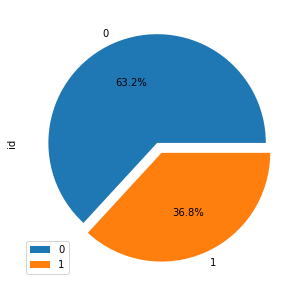

In [153]:
nai = pd.read_csv("submission_naive.csv")
pie = logs.groupby("target").count()
pie.plot.pie(y='id', figsize=(5, 5), autopct='%1.1f%%', explode=(0, 0.1))

En este modelo se observa una diferencia un poco mas notoria con respecto a la cantidad de tweets falsos que se predicen, al igual que en el modelo anterior. 
Tambien hay que tomar en cuenta que ambos modelos tienen un accuracy muy similar.

##### Resultados obtenidos comparando la predicción con la data de test

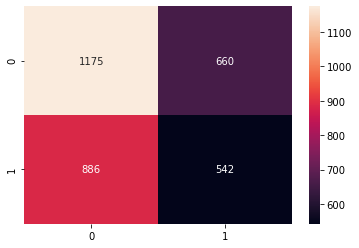

In [154]:
cm = confusion_matrix(dataTest.target, logs.target)
f = sns.heatmap(cm, annot=True, fmt='d')

Podemos observar que se obtuvieron resultados distintos cuando los comparamos, pero siempre la mayoria de tweets resultan falsos. 

## Regresión Mejorado

In [155]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [156]:
for fold_ in range(5):
    train_df=df_train[df_train.kfold!=fold_].reset_index(drop=True)
    if fold_==4:
        train_df=df_train.reset_index(drop=True)
        test_df=df_test.reset_index(drop=True)
    else:
        test_df=df_train[df_train.kfold==fold_].reset_index(drop=True)

    ##### initilize TfidfVectorizer with NLTK's word_tokenize
    ##### function as tokenizer
    tfidf_vec=TfidfVectorizer(
        tokenizer=word_tokenize,
        token_pattern=None)
    #### fit count_vec on training data reviews
    tfidf_vec.fit(train_df.text)
    #transform training and validation data reviews
    x_train=tfidf_vec.transform(train_df.text)
    x_test=tfidf_vec.transform(test_df.text)
    # initialize logistic regression model
    model_logistic_2=linear_model.LogisticRegression(max_iter=1000)
    # fit the model on training data reviews and sentiment
    model_logistic_2.fit(x_train,train_df.target)
    preds_logtfidf=model_logistic_2.predict(x_test)
    ##Calculate accuracy
    if fold_!=4:
        accuracy=metrics.accuracy_score(test_df.target,preds_logtfidf)
        print(f"Fold:{fold_}")
        print(f"Accuracy={accuracy}")
        print("")

Fold:0
Accuracy=0.7862394957983193

Fold:1
Accuracy=0.7950604308985811

Fold:2
Accuracy=0.788754598003153

Fold:3
Accuracy=0.7971623751970572



Podemos observar que el accuracy luego de las cuatro corridas realizadas al modelo se mantiene en valores similares. 

Con los tres modelos realizados para esta parte del protecto se obtuvieron resultados bastante favorables, ya que todos cuentan con un accuracy bastante alto, lo que sigue es tomar en cuenta las caracteristicas individuales, para poder trabajar con el que mejor se adapte a nuestro objetivo. 

In [157]:
import dash
from dash import html
from dash import dcc
import plotly.graph_objects as go
import plotly.express as px
from dash.dependencies import Input, Output, State


import warnings
warnings.filterwarnings("ignore")

In [216]:
app = dash.Dash()

app.layout = html.Div(id = 'parent', children = [
    html.H1(id = 'H1', children = 'Predicción de Tweets', style = {'textAlign':'center',\
                                            'marginTop':40,'marginBottom':40}),
        html.P("Modelos"),  #para texto
        dcc.Dropdown(id = 'dropdown', #menu de opciones 
        options = [
            {'label':'Naive - Bayes (Más recomendado)', 'value':'bayes'}, #lsita de opciones "label" el valor que se muestra en pantalla
            {'label': 'Regresion Logistica + Vectorizador (recomendado)', 'value':'regresionLV'}, #value es el valor del dropdown
            {'label': 'Regresion Logistica (menos recomendado)', 'value':'regresionL'},
            ],
        value = 'bayes'), #valor inicial 
    
    dcc.Textarea(
        id='text_area',
        value='',
        style={'width': '100%', 'height': 200},
    ),
    html.Button('Predecir', id='button', n_clicks=0),
    html.Button("Limpiar Texto", id = "button2", n_clicks = 0),
    html.Div(id='resultado', style={'whiteSpace': 'pre-line', "font-size": "large"})])


    
    
@app.callback(
    Output('resultado', 'children'),
    Input("dropdown", "value"),
    Input('button', 'n_clicks'),
    Input("button2", "n_clicks_2"),
    State('text_area', 'value')
)

def update_output(dropdown_value,n_clicks, n_clicks_2, text):
    
    if n_clicks > 0:
        clean_text = limpiar(text)
        if dropdown_value == "bayes":
            x_test=count_vec.transform(clean_text)
            resultado = model_naive.predict(x_test)
            text = ""
            
            return 'Usando NAIVE - BAYES: \n{}'.format(resultado_class(resultado))
        elif dropdown_value == "regresionL":
            x_test=count_vec.transform(clean_text)
            resultado = model_logistic.predict(x_test)

            
            return 'Usando Regresión Lineal :  \n{}'.format(resultado_class(resultado))
        else:
            x_test=count_vec.transform(clean_text)
            resultado = model_logistic_2.predict(x_test)

            
            return 'Usando Regresión Lineal +  Vectorizador: \n{}'.format(resultado_class(resultado))
    
    if n_clicks_2 > 0: 
        text = ""
        nclicks_2 = 0
        
    

In [217]:
if __name__ == '__main__': 
    app.run_server()

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:8050/ (Press CTRL+C to quit)
127.0.0.1 - - [15/Nov/2021 19:43:57] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [15/Nov/2021 19:43:57] "GET /_dash-layout HTTP/1.1" 200 -
127.0.0.1 - - [15/Nov/2021 19:43:57] "GET /_dash-dependencies HTTP/1.1" 200 -
127.0.0.1 - - [15/Nov/2021 19:43:57] "GET /_dash-component-suites/dash/dcc/async-dropdown.js HTTP/1.1" 200 -


Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "C:\Users\jiio2\anaconda3\lib\site-packages\flask\app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "C:\Users\jiio2\anaconda3\lib\site-packages\flask\app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "C:\Users\jiio2\anaconda3\lib\site-packages\flask\app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "C:\Users\jiio2\anaconda3\lib\site-packages\flask\_compat.py", line 39, in reraise
    raise value
  File "C:\Users\jiio2\anaconda3\lib\site-packages\flask\app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "C:\Users\jiio2\anaconda3\lib\site-packages\flask\app.py", line 1936, in dispatch_request
    return self.view_functions[rule.endpoint](**req.view_args)
  File "C:\Users\jiio2\AppData\Roaming\Python\Python38\site-packages\dash\dash.py", line 1336, in dispatch


127.0.0.1 - - [15/Nov/2021 19:43:57] "POST /_dash-update-component HTTP/1.1" 500 -
127.0.0.1 - - [15/Nov/2021 19:44:01] "POST /_dash-update-component HTTP/1.1" 200 -
